In [5]:
import cv2
from keras.models import load_model
import numpy as np

In [38]:
model = load_model('/Users/abdul/Documents/VS-Code/42028-Deep-Learning-and-CNN/Code/model_with_background.h5')


conversion of an image to 160 x 90

In [2]:
import cv2

# Create a VideoCapture object
cap = cv2.VideoCapture(0)  # 0 is usually the built-in webcam

# Set camera resolution
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)  # Replace with desired width
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)  # Replace with desired height

while True:
    # Read frame from the camera
    ret, frame = cap.read()

    # Display the frame
    cv2.imshow("Video", frame)

    # Wait for the 'q' key to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the VideoCapture object and close any open windows
cap.release()
cv2.destroyAllWindows()


In [3]:
import cv2

camera = cv2.VideoCapture(0)

codec = 0x47504A4D  # MJPG
camera.set(cv2.CAP_PROP_FPS, 30.0)
camera.set(cv2.CAP_PROP_FOURCC, codec)
camera.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

while (1):
    retval, im = camera.read(0)
    cv2.imshow("image", im)

    k = cv2.waitKey(1) & 0xff
    if k == 27:
        break

camera.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

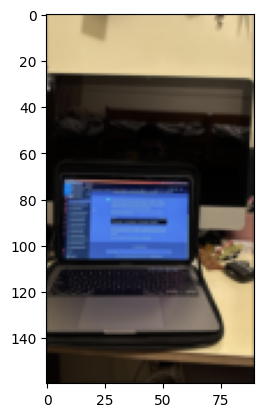

In [32]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

img_path = '/Users/abdul/Documents/VS-Code/42028-Deep-Learning-and-CNN/Code/IMG_5693.JPG'
img = Image.open(img_path)

# Try to get the EXIF data
try:
    exif_data = img._getexif()
    if 274 in exif_data:    # 274 is the EXIF tag for Orientation
        orientation = exif_data[274]

        # Handle the orientation
        if orientation == 3:
            img = img.rotate(180, expand=True)
        elif orientation == 6:
            img = img.rotate(-90, expand=True)
        elif orientation == 8:
            img = img.rotate(90, expand=True)
except:
    pass

image = np.array(img)

# Resize image using PIL
new_height = 1280
aspect_ratio = image.shape[1]/image.shape[0] 
new_width = round(new_height * aspect_ratio)
img = img.resize((new_width, new_height))

# Convert PIL Image back to NumPy array
resized_image = np.array(img)

# Crop image to required size
def crop_image(image, new_shape):
    current_shape = image.shape
    y_start = (current_shape[0] - new_shape[0]) // 2
    y_end = y_start + new_shape[0]
    x_start = (current_shape[1] - new_shape[1]) // 2
    x_end = x_start + new_shape[1]
    cropped_image = image[y_start:y_end, x_start:x_end, :]
    return cropped_image

cropped_image = crop_image(resized_image, (1280, 720, 3))

# Final resize for CNN model
final_image = resize(cropped_image, (160, 90, 3), mode='constant')

# Show final image
plt.imshow(final_image)
plt.show()


live video of 160 x 90

In [74]:
import cv2
from PIL import Image, ImageOps
import numpy as np
from skimage.transform import resize

# Define the crop function
def crop_image(image, new_shape):
    current_shape = image.shape
    y_start = (current_shape[0] - new_shape[0]) // 2
    y_end = y_start + new_shape[0]
    x_start = (current_shape[1] - new_shape[1]) // 2
    x_end = x_start + new_shape[1]
    cropped_image = image[y_start:y_end, x_start:x_end, :]
    return cropped_image

# Create a VideoCapture object
cap = cv2.VideoCapture(0)  # 0 is usually the built-in webcam

try:
    while True:
        # Read a frame from the camera
        ret, frame = cap.read()

        # If frame is read correctly, ret is True
        if not ret:
            print("Can't receive frame. Exiting ...")
            break

        # Convert the frame to PIL Image
        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # Resize the frame
        new_height = 1280
        aspect_ratio = img.size[0]/img.size[1]  # PIL Image.size is in (width, height) format
        new_width = round(new_height * aspect_ratio)
        img = img.resize((new_width, new_height))

        # Convert PIL Image back to NumPy array
        resized_frame = np.array(img)

        # Crop the frame to required size
        cropped_frame = crop_image(resized_frame, (1280, 720, 3))

        # Final resize for CNN model
        final_frame = resize(cropped_frame, (160, 90, 3), mode='constant')

        # Convert the final frame back to BGR color format for displaying with cv2.imshow
        final_frame = cv2.cvtColor(final_frame.astype('float32'), cv2.COLOR_RGB2BGR)






        

        # Display the resulting frame
        cv2.imshow('frame', final_frame)

        # Wait for the user to press 'q' key to stop the loop
        if cv2.waitKey(1) == ord('q'):
            break
finally:
    # Release the VideoCapture object and close windows
    cap.release()
    cv2.destroyAllWindows()


In [82]:
import cv2
from PIL import Image
import numpy as np
from skimage.transform import resize

# Define the crop function
def crop_image(image, new_shape):
    current_shape = image.shape
    y_start = (current_shape[0] - new_shape[0]) // 2
    y_end = y_start + new_shape[0]
    x_start = (current_shape[1] - new_shape[1]) // 2
    x_end = x_start + new_shape[1]
    cropped_image = image[y_start:y_end, x_start:x_end, :]
    return cropped_image

# Load the pre-trained model
model = load_model('/Users/abdul/Documents/VS-Code/42028-Deep-Learning-and-CNN/Code/model_with_background.h5')

# Create a VideoCapture object
cap = cv2.VideoCapture(0)  # 0 is usually the built-in webcam

try:
    while True:
        # Read a frame from the camera
        ret, frame = cap.read()

        # If frame is read correctly, ret is True
        if not ret:
            print("Can't receive frame. Exiting ...")
            break

        # Convert the frame to PIL Image
        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # Resize the frame
        new_height = 1280
        aspect_ratio = img.size[0] / img.size[1]  # PIL Image.size is in (width, height) format
        new_width = round(new_height * aspect_ratio)
        img = img.resize((new_width, new_height))

        # Convert PIL Image back to NumPy array
        resized_frame = np.array(img)

        # Crop the frame to the required size
        cropped_frame = crop_image(resized_frame, (1280, 720, 3))
        cropped_np = np.array(cropped_image) #convert to np array
        resized_pre_image = resize(cropped_np, (160, 90, 3), mode='constant')
        image_batch = np.expand_dims(resized_pre_image, axis=0)
        # add an extra dimension for the batch
        image_batch = np.expand_dims(resized_pre_image, axis=0)

# Make predictions
        predictions = model.predict(image_batch)




      
        cropped_frame_rgb = cv2.cvtColor(cropped_frame, cv2.COLOR_RGB2BGR)


        # Display the resulting frame
        cv2.imshow('frame', cropped_frame_rgb)

        # Wait for the user to press 'q' key to stop the loop
        if cv2.waitKey(1) == ord('q'):
            break
finally:
    # Release the VideoCapture object and close windows
    cap.release()
    cv2.destroyAllWindows()


1/1 [==============================] - 0s 15ms/step


live keypoints


In [73]:
import cv2
from PIL import Image
import numpy as np
from skimage.transform import resize

# Define the crop function
def crop_image(image, new_shape):
    current_shape = image.shape
    y_start = (current_shape[0] - new_shape[0]) // 2
    y_end = y_start + new_shape[0]
    x_start = (current_shape[1] - new_shape[1]) // 2
    x_end = x_start + new_shape[1]
    cropped_image = image[y_start:y_end, x_start:x_end, :]
    return cropped_image

# Load the pre-trained model
model = load_model('/Users/abdul/Documents/VS-Code/42028-Deep-Learning-and-CNN/Code/model_with_background.h5')

# Create a VideoCapture object
cap = cv2.VideoCapture(0)  # 0 is usually the built-in webcam

try:
    while True:
        # Read a frame from the camera
        ret, frame = cap.read()

        # If frame is read correctly, ret is True
        if not ret:
            print("Can't receive frame. Exiting ...")
            break

        # Convert the frame to PIL Image
        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # Resize the frame
        new_height = 1280
        aspect_ratio = img.size[0] / img.size[1]  # PIL Image.size is in (width, height) format
        new_width = round(new_height * aspect_ratio)
        img = img.resize((new_width, new_height))

        # Convert PIL Image back to NumPy array
        resized_frame = np.array(img)

        # Crop the frame to the required size
        cropped_frame = crop_image(resized_frame, (1280, 720, 3))

        # Final resize for CNN model
        cc = resize(cropped_frame, (160, 90, 3), mode='constant')

        # Convert the final frame back to BGR color format for displaying with cv2.imshow
        final_frame = cv2.cvtColor(cc.astype('float32'), cv2.COLOR_RGB2BGR)

        # Expand dimensions for model prediction
        image_batch = np.expand_dims(final_frame, axis=0)
        print(cropped_frame.shape)

        # Make predictions
        predictions = model.predict(image_batch)
        print(predictions)

        # Reshape the predicted keypoints array to a (4, 2) matrix
        predicted_keypoints = np.array(predictions).reshape((4, 2))

        # Draw keypoints on the cropped frame
        for i in range(predicted_keypoints.shape[0]):
            x = int(predicted_keypoints[i][0] * cropped_frame.shape[1])
            y = int(predicted_keypoints[i][1] * cropped_frame.shape[0])
            # print(x,y)
            if x < 0:
                x = 0
            if y < 0:
                y = 0
            cropped_frame_rgb = cv2.cvtColor(cropped_frame, cv2.COLOR_RGB2BGR)

            cv2.circle(cropped_frame_rgb, (x, y), 5, (0, 255, 0), -1)


        # Display the resulting frame
        cv2.imshow('frame', cropped_frame_rgb)

        # Wait for the user to press 'q' key to stop the loop
        if cv2.waitKey(1) == ord('q'):
            break
finally:
    # Release the VideoCapture object and close windows
    cap.release()
    cv2.destroyAllWindows()


(1280, 720, 3)
1/1 [==============================] - 0s 89ms/step
[[291.4073  656.9166  338.92148 648.1986  332.19135 816.61066 283.555
  841.0929 ]]
(1280, 720, 3)
1/1 [==============================] - 0s 16ms/step
[[289.80707 660.81226 339.02945 648.15826 350.69806 822.07916 295.74496
  853.87494]]
(1280, 720, 3)
1/1 [==============================] - 0s 16ms/step
[[292.90903 662.27234 340.9747  649.06696 353.99625 818.2791  301.33902
  850.67883]]
(1280, 720, 3)
1/1 [==============================] - 0s 19ms/step
[[312.6777  690.85187 361.4225  676.054   378.5871  833.0744  322.14777
  868.03796]]
(1280, 720, 3)
1/1 [==============================] - 0s 16ms/step
[[307.74747 684.6564  357.1505  668.4268  382.673   828.3832  322.74945
  866.1786 ]]
(1280, 720, 3)
1/1 [==============================] - 0s 17ms/step
[[320.6226  685.7601  368.531   676.5162  361.78122 832.51404 306.74423
  856.8732 ]]
(1280, 720, 3)
1/1 [==============================] - 0s 15ms/step
[[253.16748 643.1

tests

In [6]:
import cv2
from keras.models import load_model

import cv2
from PIL import Image
import numpy as np
from skimage.transform import resize

# Define the crop function
def crop_image(image, new_shape):
    current_shape = image.shape
    y_start = (current_shape[0] - new_shape[0]) // 2
    y_end = y_start + new_shape[0]
    x_start = (current_shape[1] - new_shape[1]) // 2
    x_end = x_start + new_shape[1]
    cropped_image = image[y_start:y_end, x_start:x_end, :]
    return cropped_image

# Load the pre-trained model
model = load_model('/Users/abdul/Documents/VS-Code/42028-Deep-Learning-and-CNN/Code/model_with_background.h5')

# Create a VideoCapture object
cap = cv2.VideoCapture(0)  # 0 is usually the built-in webcam
codec = 0x47504A4D  # MJPG
camera.set(cv2.CAP_PROP_FPS, 30.0)
camera.set(cv2.CAP_PROP_FOURCC, codec)
camera.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)


try:
    while True:
        # Read a frame from the camera
        ret, frame = cap.read()

        # If frame is read correctly, ret is True
        if not ret:
            print("Can't receive frame. Exiting ...")
            break

        # Convert the frame to PIL Image
        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # Resize the frame
        new_height = 1280
        aspect_ratio = img.size[0] / img.size[1]  # PIL Image.size is in (width, height) format
        new_width = round(new_height * aspect_ratio)
        img = img.resize((new_width, new_height))

        # Convert PIL Image back to NumPy array
        resized_frame = np.array(img)

        # Crop the frame to the required size
        cropped_frame = crop_image(resized_frame, (1280, 720, 3))
        cropped_np = np.array(cropped_frame) #convert to np array
        resized_pre_image = resize(cropped_np, (160, 90, 3), mode='constant')
        image_batch = np.expand_dims(resized_pre_image, axis=0)
        # add an extra dimension for the batch
        image_batch = np.expand_dims(resized_pre_image, axis=0)
# ... Your previous code up to model.predict ...

        predictions = model.predict(image_batch)

        # Reshape the predicted keypoints array to a (4, 2) matrix
        predicted_keypoints = predictions.reshape((4, 2))

        # Convert the keypoints to integers
        predicted_keypoints = predicted_keypoints.astype(int)
        cropped_frame_rgb = cv2.cvtColor(cropped_frame, cv2.COLOR_RGB2BGR)


        # Copy the frame so you don't modify the original
        drawn_frame = cropped_frame_rgb.copy()

        # Plot the keypoints
        for i in range(predicted_keypoints.shape[0]):
            x = predicted_keypoints[i][0]
            y = predicted_keypoints[i][1]
            if x < 0:
                x = 0
            if y < 0:
                y = 0

            cv2.circle(drawn_frame, (x, y), radius=10, color=(0, 255, 0), thickness=-1)

        # Display the resulting frame
        cv2.imshow('frame', drawn_frame)

        # Wait for the user to press 'q' key to stop the loop
        if cv2.waitKey(1) == ord('q'):
            break
finally:
    # Release the VideoCapture object and close windows
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 17ms/step


: 